In [8]:
#LIB IMPORTATIONS
"****************************************************"

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
from numba import jit, njit
from time import time
from statsmodels.distributions import ECDF
import seaborn as sns
from sklearn.preprocessing import normalize
import collections as collec



'****************************************************'

######### GLOBAL VARIABLES


DATA_NAMES =  [f'../data/orderbooks_2/orderbooks-5limits-part{i}.parquet' for i in range(1,3)]


### SYNTHETIC-ORDER VARIABLES
TIME_BETWEEN_ORDERS = 1 #second
DISTANCE_PLACED_ORDERS = 0  #bps
LIFETIME_ORDERS = 1.01


### VOLUME-VARIATION VARIABLES
MIN_DEPTH_BPS = 0
MAX_DEPTH_BPS= 100
NUMBER_OF_LEVELS = 6
DELTA_T_VOLUMES = 1 

DEPTHS = [1, 2, 5, 10, 20, 50] #np.linspace(MIN_DEPTH_BPS, MAX_DEPTH_BPS, NUMBER_OF_LEVELS)



In [9]:
print(DEPTHS)

[1, 2, 5, 10, 20, 50]


Index(['etimestamp', 'eprice', 'etype', 'esize_ini', 'eside', 'bp0', 'bq0',
       'bp1', 'bq1', 'bp2', 'bq2', 'bp3', 'bq3', 'bp4', 'bq4', 'ap0', 'aq0',
       'ap1', 'aq1', 'ap2', 'aq2', 'ap3', 'aq3', 'ap4', 'aq4'],
      dtype='object')

In [10]:


def get_volume_differences(row, line, data,
                           ): 
    depths_to_sides_to_added_liquidity = {depth:{'B':0 , 'S': 0} for depth in DEPTHS}
    current_time_ = row[0]
    iter_line = line
    time_before = current_time_ - DELTA_T_VOLUMES
    data_iter_line = row
    limit_order_memory = []
    num_iter=0
    while data_iter_line[0] > time_before :
        num_iter += 1
        iter_line -= 1
        if iter_line < 0 : 
            break
        if (data_iter_line[2] != 'A') or data_iter_line[-1] == True : 
            data_iter_line = data[iter_line]
            continue
        limit_order_memory.append(
            {'price' : data_iter_line[1],
             'side' : data_iter_line[4], 
             'volume': data_iter_line[3]
             })
        data_iter_line = data[iter_line]
    

    
    depths_to_sides_to_prices_ini = {depth :
                                     {'B' : data_iter_line[5] *(1 - depth / 10_000) , 'S' : data_iter_line[15]* (1 + depth / 10_000) } 
                                     for depth in DEPTHS}
    

    for limit_order in limit_order_memory : 
        trade_side = limit_order['side']
        for depth in DEPTHS : 
            sides_to_prices_ini = depths_to_sides_to_prices_ini[depth]
            
            if ((trade_side == 'B') and (limit_order['price'] >= sides_to_prices_ini['B'])) or (
                (trade_side == 'S') and (limit_order['price'] <= sides_to_prices_ini['S'])) :
                depths_to_sides_to_added_liquidity[depth][trade_side] += limit_order['volume']
        

    #(depths_to_sides_to_added_liquidity[7.0])

    return depths_to_sides_to_added_liquidity
    
    


def get_diff_imbalance(vol_bid_diff, vol_ask_diff):

    if vol_bid_diff + vol_ask_diff == 0 :
        return 0
    
    imbalance =  (vol_bid_diff - vol_ask_diff) / (vol_bid_diff + vol_ask_diff)
    return imbalance





def get_differences_imbalances(depths_to_sides_to_added_liquidity):
    

    depths_to_imbalances = {depth : get_diff_imbalance(depths_to_sides_to_added_liquidity[depth]['B'],
                                                               depths_to_sides_to_added_liquidity[depth]['S'])
                                                               for depth in DEPTHS}
    
    return depths_to_imbalances 

In [11]:
def get_orders_data3(
        distance_bps = DISTANCE_PLACED_ORDERS,
        delay = LIFETIME_ORDERS, 
        data = DATA_NAMES, 
        time_between_orders = TIME_BETWEEN_ORDERS, 
        delta_t_volumes = DELTA_T_VOLUMES ):
    
    
    timestamp_start_to_feature_to_value = {}
    order_id = 0
    trade_maker_sides, trade_prices, trade_timestamps = [], [], []
    
    
    num_iter = 0
   
    
    last_order_snapshot = -1
    number_of_posted_orders = 0
    tradecimetery_to_features_to_values = []

    for name in DATA_NAMES: 
        t_start = time()
        
        data=pd.read_parquet(name)
        cols = [f'{lettre}{typ}{lev}' for lettre in ['b','a'] for lev in range(5) for typ in ['p','q'] ]
        data = data[['etimestamp','eprice', 'etype', 'esize_ini', 'eside'] + cols +['is_from_marketable']]
        dataloc = data.values
        length = len(dataloc)
        start_time=dataloc[0][0]
        
        

        for line, row in enumerate(dataloc): # we iterate over the whole dataset


            num_iter += 1
            current_time=row[0]

            line_prov=line
            while dataloc[line_prov,0] == current_time: # We look at all the trade orders that happened at the same timestamp as the current
                dataloc_line_prov = dataloc[line_prov]
                if dataloc_line_prov[2] == 'T': 
                    
                    trade_maker_sides.append(dataloc_line_prov[4])
                    trade_timestamps.append(current_time)
                    trade_prices.append(dataloc_line_prov[1])

                line_prov += 1
                if line_prov==length:
                    break
        
            if row[0] - last_order_snapshot > time_between_orders : # it has been more than a second since the last order was placed
                if row[0]- start_time <= delta_t_volumes:
                    continue 
                
                if row[5] < row[15]:
                     # We check if not in a particular case of bid > ask, and then post an order (we don't take volumes into account)
                    number_of_posted_orders += 2
                    synthetic_bid_order = row[5] * (1 - distance_bps / 10_000) #bp0
                    synthetic_ask_order = row[15] * (1 + distance_bps / 10_000)
                    depths_to_sides_to_added_liquidity = get_volume_differences(row,line,dataloc)
                    depths_to_imbalances = get_differences_imbalances(depths_to_sides_to_added_liquidity)
                    
                    #print(depths_to_imbalances)
                    # Recording the features
                    bid_order_feature_to_value = {
                        "side": "B",
                        "price": synthetic_bid_order,
                        "order_id": order_id,
                        "timestamp_insertion": row[0],
                        "lifetime": delay,
                        "executed": 'pending'
                    }
                    order_id += 1
                    ask_order_feature_to_value = {
                        "side": "S",
                        "price": synthetic_ask_order,
                        "order_id": order_id,
                        "timestamp_insertion": row[0] + 1e-6,
                        "lifetime": delay,
                        "executed": 'pending'
                    }
                    order_id+=1

                    for depth in DEPTHS :
                        
                        imbalance= depths_to_imbalances[depth]
                        bid_order_feature_to_value[f'imbalance_{depth}_bps'] = imbalance
                        ask_order_feature_to_value[f'imbalance_{depth}_bps'] = imbalance

                    
                    timestamp_start_to_feature_to_value[ask_order_feature_to_value["timestamp_insertion"]] = ask_order_feature_to_value # posting the ask order
                    timestamp_start_to_feature_to_value[bid_order_feature_to_value["timestamp_insertion"]] = bid_order_feature_to_value # posting the bid order


                    # Matching engine
                    for k in range(len(trade_prices)):
                        trade_feature_to_value = {
                            "side": trade_maker_sides[k],
                            "price": trade_prices[k],
                            "timestamp": trade_timestamps[k],
                        }
                        #if trade_feature_to_value['side'] == 'S':
                            #print('***',trade_feature_to_value['timestamp'])
                        j=0
                        while True:
                            if j >= len(timestamp_start_to_feature_to_value):
                                break

                            timestamp_start = list(timestamp_start_to_feature_to_value.keys())[j]
                            feature_to_value = timestamp_start_to_feature_to_value[timestamp_start]

                            if (current_time >feature_to_value['timestamp_insertion'] + feature_to_value['lifetime']): #the order is dead


                                feature_to_value['executed'] = False
                                feature_to_value['lifetime']=current_time - feature_to_value['timestamp_insertion']
                                tradecimetery_to_features_to_values.append(feature_to_value)
                                del timestamp_start_to_feature_to_value[timestamp_start]
                                j-=1
                            elif (trade_feature_to_value['side'] == feature_to_value['side']) & (current_time > feature_to_value['timestamp_insertion']):
                                
                                #print('side',trade_feature_to_value['side'])
                                #print('order',feature_to_value['price'])
                                #print('trade',trade_feature_to_value['price'])
                                if(((trade_feature_to_value['side'] == 'B') & (feature_to_value['price'] >= trade_feature_to_value['price'])) 
                                or ( (trade_feature_to_value['side'] == 'S') & (feature_to_value['price'] <= trade_feature_to_value['price']))):
                                
                                    feature_to_value['executed'] = True
                                    feature_to_value['lifetime']= current_time - feature_to_value['timestamp_insertion']
                                    tradecimetery_to_features_to_values.append(feature_to_value)
                                    del timestamp_start_to_feature_to_value[timestamp_start]
                                    j-=1
                            j+=1
                    trade_maker_sides, trade_prices, trade_timestamps = [], [], []
                    


                last_order_snapshot=row[0]  
        del data
        del dataloc
        
        
        print(f'calculated exec data of {name} for distance of {distance_bps} bps with a delay of {delay}s in {time()-t_start}s')
    

    return tradecimetery_to_features_to_values

In [6]:
def get_exec_numbers(**kwargs ):


    
    results = get_orders_data3(**kwargs)
                              
    limits_to_bucket = {round(-0.9 + 0.2 * i, 2):{'min_': round(-1 + 0.2 * i, 2) , 'max_' : round(-0.8 + 0.2 * i, 2) } for i in range(10) }
    levels_to_buckets_to_bid_orders_to_executed = {level_ :
                                                 {round(-0.9 + 0.2 * i, 2): {'executed' : 0 , 'total_bucket' : 0} 
                                                  for i in range (10)}
                                                  for level_ in DEPTHS
                                                 }
    levels_to_buckets_to_ask_orders_to_executed = {level_ :
                                                 {round(-0.9 + 0.2 * i, 2): {'executed' : 0 , 'total_bucket' : 0} 
                                                  for i in range (10)}
                                                  for level_ in DEPTHS
                                                 } 

    for trade in results: 
        

        for _, level in enumerate(DEPTHS) :
            imbalance = trade[f'imbalance_{level}_bps']
           
        
            correct_middle = np.NaN
            for middle in limits_to_bucket.keys(): 
                bucket = limits_to_bucket[middle]
                if ((bucket['min_'] <= imbalance) & (bucket['max_'] >= imbalance)) : 
                    correct_middle = middle
                    break

            if trade['side'] == 'B':
                buckets_to_bid_orders_to_executed = levels_to_buckets_to_bid_orders_to_executed[level][correct_middle]

                buckets_to_bid_orders_to_executed['total_bucket'] += 1
                if trade['executed'] == True: 
                    buckets_to_bid_orders_to_executed['executed'] += 1
            else :
                buckets_to_ask_orders_to_executed = levels_to_buckets_to_ask_orders_to_executed[level][correct_middle]
                buckets_to_ask_orders_to_executed['total_bucket'] += 1
                if trade['executed'] == True: 
                    buckets_to_ask_orders_to_executed['executed'] += 1


    
        

    return levels_to_buckets_to_ask_orders_to_executed, levels_to_buckets_to_bid_orders_to_executed








def get_exec_probas(**kwargs):
    levels_to_buckets_to_ask_orders_to_executed, levels_to_buckets_to_bid_orders_to_executed = get_exec_numbers(**kwargs)
    levels_to_buckets_to_ask_probas = {level:{} for level in DEPTHS}
    levels_to_buckets_to_bid_probas = {level:{} for level in DEPTHS}
    timestamps = levels_to_buckets_to_ask_orders_to_executed[DEPTHS[0]].keys()
    for key in timestamps:
        for level in levels_to_buckets_to_ask_orders_to_executed.keys():
            doc_ask=levels_to_buckets_to_ask_orders_to_executed[level][key]
            doc_bid=levels_to_buckets_to_bid_orders_to_executed[level][key]
            total_bucket = doc_ask['total_bucket']
           
            levels_to_buckets_to_ask_probas[level][key] = doc_ask['executed']/(total_bucket) if total_bucket != 0 else 0
            levels_to_buckets_to_bid_probas[level][key] = doc_bid['executed']/(total_bucket) if total_bucket !=0 else 0



    return levels_to_buckets_to_bid_probas, levels_to_buckets_to_ask_probas


In [12]:
'''get_exec_probas(distance_bps = DISTANCE_PLACED_ORDERS,
        delay = LIFETIME_ORDERS, 
        data = DATA_NAMES, 
        time_between_orders = TIME_BETWEEN_ORDERS, 
        delta_t_volumes = DELTA_T_VOLUMES ))'''

calculated exec data of ./data/orderbooks_2/orderbooks-5limits-part1.parquet for distance of 0 bps with a delay of 1.01s in 2.8989126682281494s
calculated exec data of ./data/orderbooks_2/orderbooks-5limits-part2.parquet for distance of 0 bps with a delay of 1.01s in 3.0935730934143066s
({1: {-0.9: 0.2768199233716475, -0.7: 0.23785803237858033, -0.5: 0.2182061579651941, -0.3: 0.2384393063583815, -0.1: 0.23054755043227665, 0.1: 0.19937205651491366, 0.3: 0.1762652705061082, 0.5: 0.1840607210626186, 0.7: 0.17073170731707318, 0.9: 0.1898989898989899}, 2: {-0.9: 0.26883910386965376, -0.7: 0.24351050679851668, -0.5: 0.2534562211981567, -0.3: 0.23314917127071824, -0.1: 0.22538552787663108, 0.1: 0.2185430463576159, 0.3: 0.1842456608811749, 0.5: 0.16333333333333333, 0.7: 0.18141592920353983, 0.9: 0.16379310344827586}, 5: {-0.9: 0.24363636363636362, -0.7: 0.23488773747841105, -0.5: 0.24381625441696114, -0.3: 0.2402464065708419, -0.1: 0.22164048865619546, 0.1: 0.2168421052631579, 0.3: 0.192532088

calculated exec data of ./orderbooks_2/orderbooks-5limits-part1.parquet for distance of 0 bps with a delay of 1.01s in 3.343045234680176s
calculated exec data of ./orderbooks_2/orderbooks-5limits-part2.parquet for distance of 0 bps with a delay of 1.01s in 4.750307083129883s


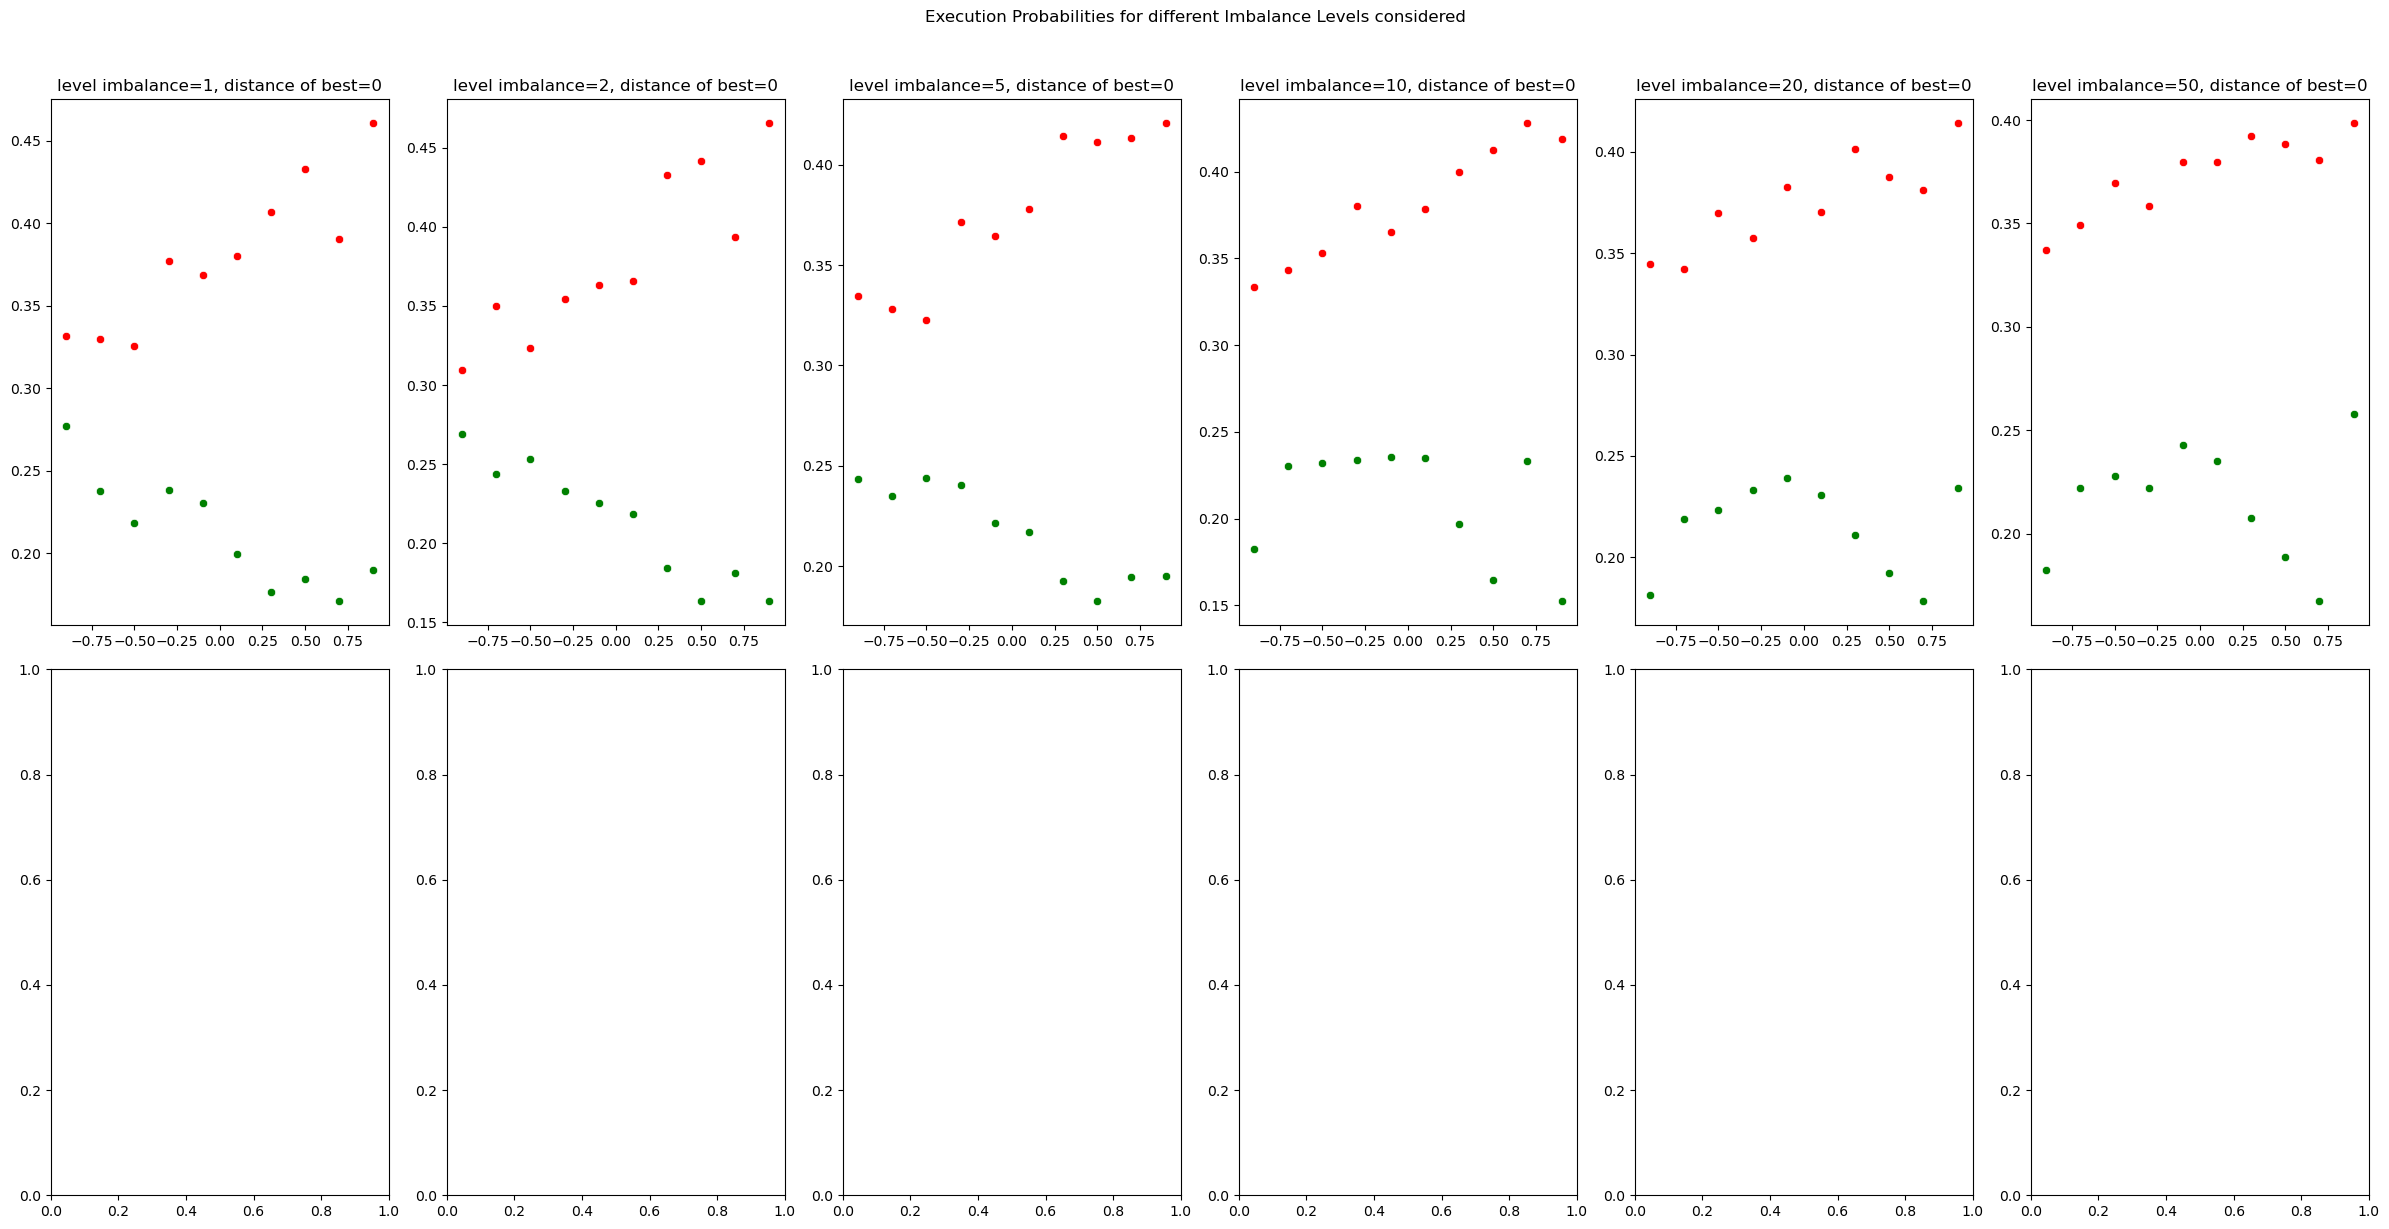

In [11]:
n_rows = 2
n_cols = len(DEPTHS)

# create a figure and a grid of subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols,12))

# to keep track of where the next subplot should be
row = 0
col = 0

# iterate through your sets of parameters

for distance_in_bps in [0] : # Where our synthetic order is
    levels_to_buckets_to_bid_probas, levels_to_buckets_to_ask_probas = get_exec_probas(distance_bps = distance_in_bps,
        delay = LIFETIME_ORDERS, 
        data = DATA_NAMES, 
        time_between_orders = TIME_BETWEEN_ORDERS, 
        delta_t_volumes = DELTA_T_VOLUMES )
    
    
    for level in DEPTHS:
        x_ =levels_to_buckets_to_ask_probas[level].keys()
        sns.scatterplot(x=list(x_), y=list(levels_to_buckets_to_ask_probas[level].values()), color='red', ax=axs[row, col])
        sns.scatterplot(x=list(x_), y=list(levels_to_buckets_to_bid_probas[level].values()), color='green', ax=axs[row, col])
        
        # set the title of each subplot as the parameters tuple
        axs[row, col].set_title( f'level imbalance={level}, distance of best={distance_in_bps}')
        
        
        #update row and col to point to the next subplot
        col += 1
        if col == n_cols:
            col = 0
            row += 1

# add a title for the whole figure
fig.suptitle(f'Execution Probabilities for different Imbalance Levels considered', y = 1.02)

# improve layout
plt.tight_layout()
plt.show()